In [1]:
setwd(here::here())

In [2]:
library("metacell")
library("Matrix")
library("ggplot2")
library("ggrepel")
library("ggpubr")
library("tgstat")
library("dplyr")
library("zoo")
library("qvalue")
library("devtools")
library("data.table")
library("tidyverse")
library("tglkmeans")
library('RColorBrewer')


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: usethis


Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.2     v purrr   0.3.4
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.0     v forcats 1.0.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x data.table::between() masks dplyr::between()
x tidyr::expand()       masks Matrix::expand()
x dplyr::filter()       masks stats::filter()
x data.table::first()   masks dplyr::first()
x dplyr::lag()          masks stats::lag()
x data.table::last()    masks dp

In [3]:
source("scripts/manifold_2d_proj_hr.R")
scdb_init("scrna_db/", force_reinit=T)

fig_dir <- "figs/"
if(!dir.exists(fig_dir)) dir.create(fig_dir)
scfigs_init(fig_dir)

mat_exe <- scdb_mat("exe")
mc_exe <- scdb_mc("exe")
gset_exe = scdb_gset("exe")
mc2d_exe <- scdb_mc2d(id = "exe_umap")
md_exe <- mat_exe@cell_metadata[names(mc_exe@mc),]

mat_emb <- scdb_mat("emb")
mc_emb <- scdb_mc("emb")
gset_emb = scdb_gset("emb")
mc2d_emb <- scdb_mc2d(id = "emb_umap")
md_emb <- mat_emb@cell_metadata[names(mc_emb@mc),]

mat_embexe <- scdb_mat("embexe")
mc_embexe <- scdb_mc("embexe_recolored")
mc2d_embexe <- scdb_mc2d(id = "embexe_recolored_umap")
md_embexe <- mat_embexe@cell_metadata[names(mc_embexe@mc),]

initializing scdb to scrna_db/



In [4]:
scdb_init("scrna_db_mm10_star/", force_reinit=T)

mc_wt = scdb_mc("mm_embexe")
mat_wt = scdb_mat("mm_embexe")

mat_all = scdb_mat('embexe_bmp4_og2_stelzer_star')
mc_all <- scdb_mc("embexe_bmp4_og2_star")
md_all <- mat_all@cell_metadata[colnames(mat_all@mat),]

cmp_annot = readRDS('data/cmp_annot_embexe_bmp4.RData')
cmp_time = read.table("data/embexe_bmp4/time_match/time_match_summary.txt", header = T)
wt_age = read.table('data/embexe.transcriptional_rank_developmental_time_with_age_group.tsv',sep = '\t',h = T)

cmp_time = cmp_time  %>% left_join( wt_age %>% select(transcriptional_rank,developmental_time,age_group,morphological_stage) %>% rename(best_rank_query = transcriptional_rank))

initializing scdb to scrna_db_mm10_star/

Joining, by = "best_rank_query"


In [5]:
germline_ko_embryos = c("x4e26_Embryo_ExE_Bmp4_KO","x4e37_Embryo_ExE_Bmp4_KO",'x6e9_Embryo_ExE_Bmp4_KO',
                          "x4e34_Embryo_ExE_Bmp4_KO","x4e35_Embryo_ExE_Bmp4_KO")

germline_control_embryos = c('x4e19_Embryo_ExE_Bmp4_KO','x4e22_Embryo_ExE_Bmp4_KO',
                    'x4e31_Embryo_ExE_Bmp4_KO','x6e3_Embryo_ExE_Bmp4_KO',
                    'x6e2_Embryo_ExE_Bmp4_KO','x6e1_Embryo_ExE_Bmp4_KO',
                    'x6e6_Embryo_ExE_Bmp4_KO','x6e4_Embryo_ExE_Bmp4_KO')

In [6]:
tetraploid_ko_embryos = c('x7e14_Embryo_Bmp4_KO',
                          'x7e111_Embryo_Bmp4_KO',
                          'x7e17_Embryo_Bmp4_KO',
                          'x8e11_Embryo_Bmp4_KO',
                          'x8e23_Embryo_Bmp4_KO',
                          'x10e3_Embryo_Bmp4_KO',
                          'x10e1_Embryo_Bmp4_KO',
                          'x10e2_Embryo_Bmp4_KO',
                          'x10e9_Embryo_Bmp4_KO',
                          'x8e21_Embryo_Bmp4_KO',
                          'x8e22_Embryo_Bmp4_KO',
                          'x10e5_Embryo_Bmp4_KO',
                          'x10e7_Embryo_Bmp4_KO',
                          'x10e12_Embryo_Bmp4_KO',
                          'x10e13_Embryo_Bmp4_KO',
                          'x10e14_Embryo_Bmp4_KO',
                          'x10e16_Embryo_Bmp4_KO',
                          'x10e15_Embryo_Bmp4_KO')

tetraploid_control_embryos = c('x10c3_Embryo_Bmp4_KO','x10c5_Embryo_Bmp4_KO',
                        'x10c6_Embryo_Bmp4_KO','x10c10_Embryo_Bmp4_KO')

In [7]:
col_to_ct =  mc_embexe@color_key$group
names(col_to_ct) = mc_embexe@color_key$color
ct_to_col = mc_embexe@color_key$color
names(ct_to_col) = mc_embexe@color_key$group

shades_rdbu <- rev(colorRampPalette(RColorBrewer::brewer.pal(11,name = "RdBu"))(100))
shades_blues <- colorRampPalette(RColorBrewer::brewer.pal(9,"Blues"))(100)
shades_reds <- colorRampPalette(RColorBrewer::brewer.pal(9,"Reds"))(100)
shades_yellows <- colorRampPalette(RColorBrewer::brewer.pal(9,"YlOrBr"))(100)
shades_greys <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greys"))(100)
shades_greens <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greens"))(100)
shades_purples <- colorRampPalette(RColorBrewer::brewer.pal(9,"BuPu"))(100)

In [8]:
exe_project_cells = rownames(md_embexe)[(md_embexe[,"Experiment"] != "Wildtype project") & (md_embexe$embryo %in% wt_age$embryo)]

emb_age_df = unique(md_embexe[exe_project_cells,c("embryo","transcriptional_rank","developmental_time")])
emb_age_df = emb_age_df[order(emb_age_df$transcriptional_rank),]

sc_time_annot = data.frame("cell" = exe_project_cells, "embryo" = md_embexe[exe_project_cells,"embryo"])
sc_time_annot = left_join(sc_time_annot,emb_age_df,by = "embryo")
f = !is.na(sc_time_annot$developmental_time)
sc_time = sc_time_annot$developmental_time[f]
names(sc_time) = sc_time_annot$cell[f]

mc_time = tapply(sc_time,mc_embexe@mc[names(sc_time)],mean)

In [9]:
plot_size <- function(w,h){
    options(repr.plot.width=w, repr.plot.height=h)
}

In [10]:
bad_genes <- read.table('data/embexe.bad_genes.txt')[,1]
batch_genes <- read.table('data/bmp4_ko_expression_analysis_bad_genes.tsv')[,1]
batch_genes <- setdiff(batch_genes, grep("Ifitm", batch_genes, v = T))

bad_gns <- unique(c(grep("Hsp", rownames(mat_all@mat),v=T, ignore.case = T),
                            grep("BEX", rownames(mat_all@mat),v=T, ignore.case = T),
                            grep("MT", rownames(mat_all@mat),v=T, ignore.case = T),
                             grep("CDK",rownames(mat_all@mat),v=T, ignore.case = T),
                            grep("RN[0-9]", rownames(mat_all@mat),v=T, ignore.case = T),
                     grep("Nduf", rownames(mat_all@mat),v=T, ignore.case = T),
                     grep("Mrp", rownames(mat_all@mat),v=T, ignore.case = T),
                    grep("\\bcox", rownames(mat_all@mat),v=T, ignore.case = T),
                     grep("\\bRp[l|s]", rownames(mat_all@mat),v=T, ignore.case = T),
                    "Top2a", "Ube2c", "Pcna", "Mki67", "Cenpf","Hist1h1a", "Hist1h1b"))

bad_genes <- union(bad_genes, bad_gns)
bad_genes <- union(bad_genes, batch_genes)

genes_f <- rownames(mat_all@mat)[! rownames(mat_all@mat) %in% bad_genes]

In [11]:
included_colors = mc_embexe@color_key$color[c(1:38,43:50)]
all_included_cells = names(mc_all@mc)[mc_all@colors[mc_all@mc] %in% included_colors]

wt_cells = names(mc_embexe@mc)[mc_embexe@colors[mc_embexe@mc] %in% included_colors]
wt_cells = wt_cells[ !is.na(mat_all@cell_metadata[wt_cells,"developmental_time"])]
wt_cells = wt_cells[mat_all@cell_metadata[wt_cells,"Experiment"] != "Wildtype project"]
wt_cells = wt_cells[mat_all@cell_metadata[wt_cells,"developmental_time"] > 7.9]
wt_cells = intersect(wt_cells, names(mc_all@mc))

In [12]:
germline_ko_cells <- rownames(mat_all@cell_metadata[names(mc_all@mc),])[mat_all@cell_metadata[names(mc_all@mc),"embryo"] %in% germline_ko_embryos]
germline_ko_cells <- intersect(germline_ko_cells, all_included_cells)

germline_ctrl_cells <- rownames(mat_all@cell_metadata[names(mc_all@mc),])[mat_all@cell_metadata[names(mc_all@mc),"embryo"] %in% germline_control_embryos]
germline_ctrl_cells <- intersect(germline_ctrl_cells, all_included_cells)

tetraploid_ko_cells <- rownames(mat_all@cell_metadata[names(mc_all@mc),])[mat_all@cell_metadata[names(mc_all@mc),"embryo"] %in% tetraploid_ko_embryos]
tetraploid_ko_cells <- intersect(tetraploid_ko_cells, all_included_cells)

tetraploid_ctrl_cells <- rownames(mat_all@cell_metadata[names(mc_all@mc),])[mat_all@cell_metadata[names(mc_all@mc),"embryo"] %in% tetraploid_control_embryos]
tetraploid_ctrl_cells <- intersect(tetraploid_ctrl_cells, all_included_cells)

####################################################################################################################

mutants_df <- read.csv("data/embs_bmp4_muts.csv")
embryonic_ko_ind <- grep("4n_x", x = mutants_df$plate, ignore.case = T)
germline_ko_ind <- grep("germline_x", x = mutants_df$plate, ignore.case = T)

embryonic_ko_df <- mutants_df[ embryonic_ko_ind,]
embryonic_ko_df <- embryonic_ko_df %>% left_join(cmp_time %>% select(embryo,developmental_time))

germline_ko_df <- mutants_df[ germline_ko_ind,]
germline_ko_df <- germline_ko_df %>% left_join(cmp_time %>% select(embryo,developmental_time))

germline_ko_embryos_old <- unique(germline_ko_df[germline_ko_df$embryo %in% germline_ko_embryos & germline_ko_df$developmental_time > 7.9,"embryo"])
tetraploid_ko_embryos_old <- unique(embryonic_ko_df[embryonic_ko_df$embryo %in% tetraploid_ko_embryos & embryonic_ko_df$developmental_time > 7.9,"embryo"])

germline_ko_cells_old <- rownames(md_all[germline_ko_cells,])[md_all[germline_ko_cells,"embryo"] %in% germline_ko_embryos_old]
tetraploid_ko_cells_old <- rownames(md_all[tetraploid_ko_cells,])[md_all[tetraploid_ko_cells,"embryo"] %in% tetraploid_ko_embryos_old]

Joining, by = "embryo"
Joining, by = "embryo"


Joining, by = "embryo"
Joining, by = "embryo"


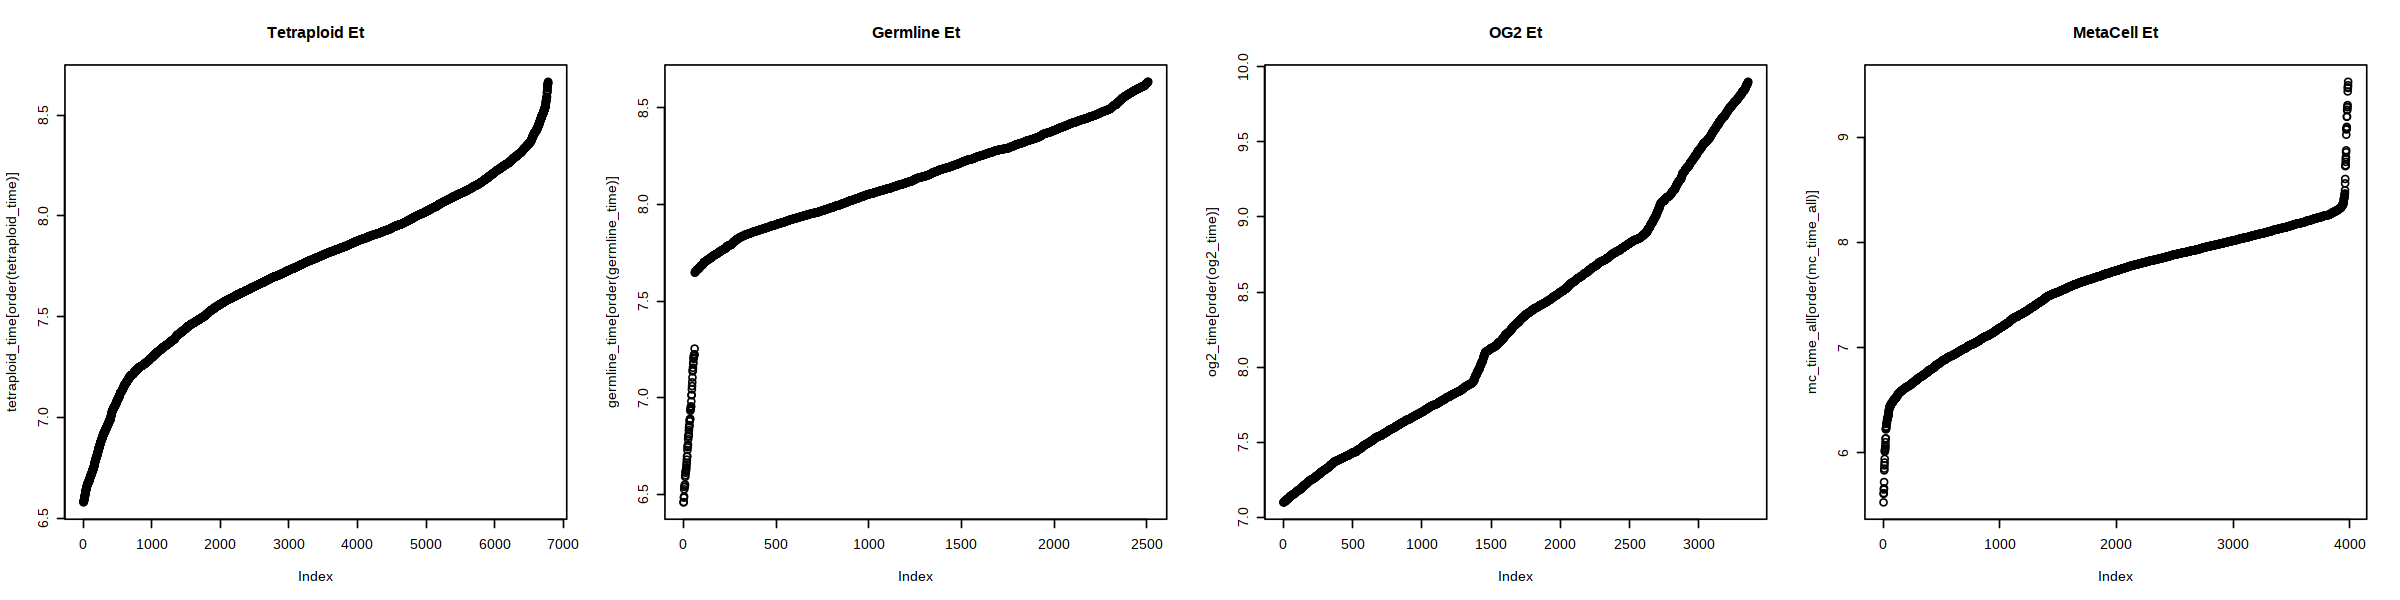

In [13]:
options(repr.plot.width=20, repr.plot.height=5)
par(mfrow = c(1,4))

sd <- .4

tetraploid_time_df <- unique(embryonic_ko_df[,-2])
tetraploid_time_df <- tetraploid_time_df[,c("embryo","developmental_time")]
tetraploid_time_sc_df <- left_join(mat_all@cell_metadata[ tetraploid_ko_cells,c("cell","embryo")],cmp_time)
tetraploid_time_sc_df <- tetraploid_time_sc_df[,c("cell","developmental_time")]
rownames(tetraploid_time_sc_df) <- tetraploid_time_sc_df$cell

tetraploid_time <- tetraploid_time_sc_df$developmental_time
tetraploid_time <- tetraploid_time + runif(n = length(tetraploid_time),min = -sd,max = sd)
names(tetraploid_time) <- tetraploid_time_sc_df$cell
plot(tetraploid_time[order(tetraploid_time)], main = "Tetraploid Et")

#################

germline_time_df <- unique(germline_ko_df[,-2])
germline_time_df <- germline_time_df[,c("embryo","developmental_time")]
germline_time_sc_df <- left_join(mat_all@cell_metadata[ germline_ko_cells,c("cell","embryo")],cmp_time)
germline_time_sc_df <- germline_time_sc_df[,c("cell","developmental_time")]
rownames(germline_time_sc_df) <- germline_time_sc_df$cell

germline_time <- germline_time_sc_df$developmental_time
germline_time <- germline_time + runif(n = length(germline_time),min = -sd,max = sd)
names(germline_time) <- germline_time_sc_df$cell
plot(germline_time[order(germline_time)], main = "Germline Et")

#################

og2_cells <- rownames(mat_all@cell_metadata[ mat_all@cell_metadata$Experiment == "PGC project",])
og2_cells <- intersect(og2_cells, names(mc_all@mc))

og2_genotype_to_time = c('E8.5 OG2' = 8.5,'E7.5 OG2' = 7.5,'E9.5 OG2' = 9.5,'E8.75 OG2' = 8.75)
og2_time = ifelse(mat_all@cell_metadata[ og2_cells,"Genotype"] %in% c('E8.5 OG2','E7.5 OG2','E9.5 OG2','E8.75 OG2'),
                  og2_genotype_to_time[mat_all@cell_metadata[ og2_cells,"Genotype"]],7.75)

og2_time <- og2_time + runif(n = length(og2_time),min = -sd,max = sd)
names(og2_time) = og2_cells
plot(og2_time[order(og2_time)], main = "OG2 Et")

#################

md_all <- mat_all@cell_metadata[names(mc_all@mc),]
md_all[names(tetraploid_time),"developmental_time"] <- as.numeric(tetraploid_time)
md_all[names(germline_time),"developmental_time"] <- as.numeric(germline_time)
md_all[names(og2_time),"developmental_time"] <- as.numeric(og2_time)
md_all <- md_all[!is.na(md_all$developmental_time),]

cells_with_time_and_mc <- intersect(rownames(md_all), names(mc_all@mc))
mc_time_all <- tapply(md_all[cells_with_time_and_mc,"developmental_time"], 
                      mc_all@mc[cells_with_time_and_mc],mean)
plot(mc_time_all[order(mc_time_all)], main = "MetaCell Et")

In [14]:
ct_col_pgc_lineage <- c("#FACB12", "#8870ad","#532C8A")

pgc_lineage_cells.all <- cells_with_time_and_mc[mc_all@colors[mc_all@mc[cells_with_time_and_mc]] %in% ct_col_pgc_lineage]

egc_pgc = t(tgs_matrix_tapply(x = mat_all@mat[genes_f,pgc_lineage_cells.all],mc_all@mc[pgc_lineage_cells.all],sum))
egc_pgc = t(t(egc_pgc)/colSums(egc_pgc))
legc_pgc = log2(egc_pgc + 1e-5)

egc = t(tgs_matrix_tapply(x = mat_all@mat[genes_f,cells_with_time_and_mc],mc_all@mc[cells_with_time_and_mc],sum))
egc_n = t(t(egc)/colSums(egc))
legc = log2(egc_n + 1e-5)

In [15]:
min_gexp <- -13
fc1 <- 4
fc2 = 1.5
k = 5
seed = 12

pgc_mcs <- unique(which(mc_all@colors == "#FACB12"))
pgc_mcs <- intersect(pgc_mcs, colnames(egc_pgc))

allantois_mcs <- unique(which(mc_all@colors == "#532C8A"))
allantois_mcs <- intersect(allantois_mcs, colnames(egc_pgc))

exm_mcs <- unique(which(mc_all@colors == "#8870ad"))
exm_mcs <- intersect(exm_mcs, colnames(egc_pgc))

dge1 <- matrix(apply(log2(egc_pgc + 1e-5),1,min),dimnames = list(c(row.names(egc_pgc))))
dge2 <- matrix(apply(log2(egc_pgc + 1e-5),1,max),dimnames = list(c(row.names(egc_pgc))))
temp <- cbind(dge2[,1],dge1[,1])

colnames(temp) <- c("gexp.max", "gexp.min")
temp <- as.data.frame(temp)

temp$diff <- temp$gexp.max - temp$gexp.min
gns_by_exp <- rownames(temp)[temp$gexp.max > min_gexp]
gns_by_fc <- rownames(temp)[temp$diff > fc1]
gns_f1 <- intersect(gns_by_exp,gns_by_fc)

abs_df_diff <- abs(matrix(apply(log2(egc_pgc[gns_f1,pgc_mcs] + 1e-5),1,max),dimnames = list(gns_f1)) - matrix(apply(log2(egc_pgc[gns_f1,allantois_mcs] + 1e-5),1,max),dimnames = list(gns_f1)))
f2 = abs_df_diff[,1] > fc2
gns_f2 <- gns_f1[f2]

legc_pgc_n = legc_pgc - rowMeans(legc_pgc)

library("tglkmeans")

km_cl = TGL_kmeans(df = legc_pgc_n[gns_f2,],
                   k = k,
                   id_column = F,
                   seed = seed)

gene_cluster = km_cl$cluster

gene_cluster = gene_cluster[order(as.numeric(gene_cluster))]

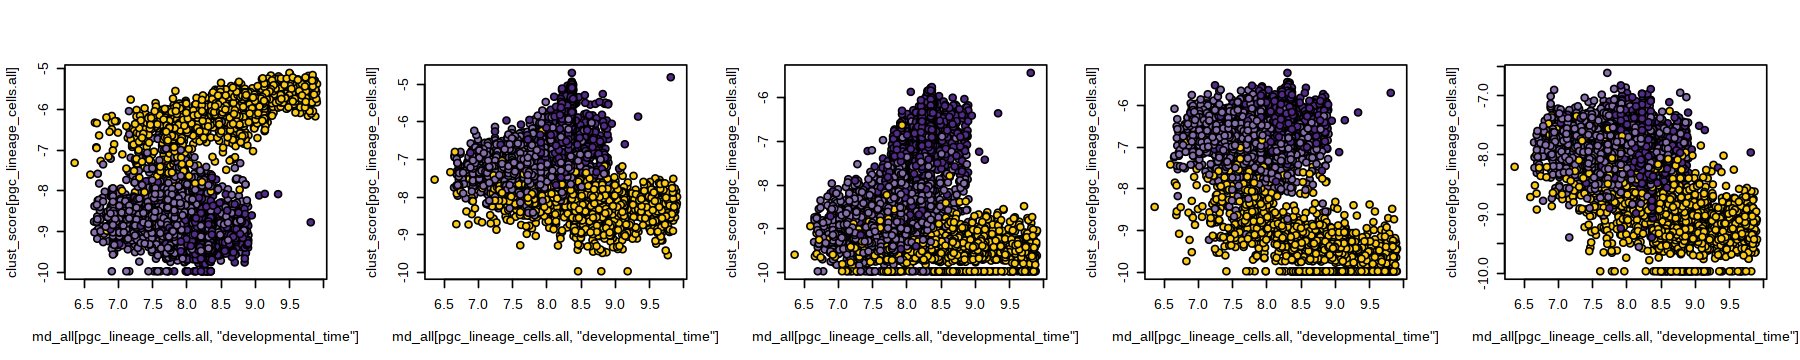

In [16]:
plot_size(15,3)
par(mfrow = c(1,5))

cluster <- 1
clust_gene <- names(gene_cluster)[as.numeric(gene_cluster) == cluster]

clust_score = colSums(mat_all@mat[clust_gene,pgc_lineage_cells.all])/colSums(mat_all@mat[,pgc_lineage_cells.all])
clust_score <- log2(clust_score + 1e-3)

plot(md_all[pgc_lineage_cells.all,"developmental_time"], clust_score[pgc_lineage_cells.all],pch = 21, cex = 1,
     bg = mc_all@colors[mc_all@mc[pgc_lineage_cells.all]])

cluster <- 2
clust_gene <- names(gene_cluster)[as.numeric(gene_cluster) == cluster]

clust_score = colSums(mat_all@mat[clust_gene,pgc_lineage_cells.all])/colSums(mat_all@mat[,pgc_lineage_cells.all])
clust_score <- log2(clust_score + 1e-3)

plot(md_all[pgc_lineage_cells.all,"developmental_time"], clust_score[pgc_lineage_cells.all],pch = 21, cex = 1,
     bg = mc_all@colors[mc_all@mc[pgc_lineage_cells.all]])

cluster <- 3
clust_gene <- names(gene_cluster)[as.numeric(gene_cluster) == cluster]

clust_score = colSums(mat_all@mat[clust_gene,pgc_lineage_cells.all])/colSums(mat_all@mat[,pgc_lineage_cells.all])
clust_score <- log2(clust_score + 1e-3)

plot(md_all[pgc_lineage_cells.all,"developmental_time"], clust_score[pgc_lineage_cells.all],pch = 21, cex = 1,
     bg = mc_all@colors[mc_all@mc[pgc_lineage_cells.all]])

cluster <- 4
clust_gene <- names(gene_cluster)[as.numeric(gene_cluster) == cluster]

clust_score = colSums(mat_all@mat[clust_gene,pgc_lineage_cells.all])/colSums(mat_all@mat[,pgc_lineage_cells.all])
clust_score <- log2(clust_score + 1e-3)

plot(md_all[pgc_lineage_cells.all,"developmental_time"], clust_score[pgc_lineage_cells.all],pch = 21, cex = 1,
     bg = mc_all@colors[mc_all@mc[pgc_lineage_cells.all]])

cluster <- 5
clust_gene <- names(gene_cluster)[as.numeric(gene_cluster) == cluster]

clust_score = colSums(mat_all@mat[clust_gene,pgc_lineage_cells.all])/colSums(mat_all@mat[,pgc_lineage_cells.all])
clust_score <- log2(clust_score + 1e-3)

plot(md_all[pgc_lineage_cells.all,"developmental_time"], clust_score[pgc_lineage_cells.all],pch = 21, cex = 1,
     bg = mc_all@colors[mc_all@mc[pgc_lineage_cells.all]])

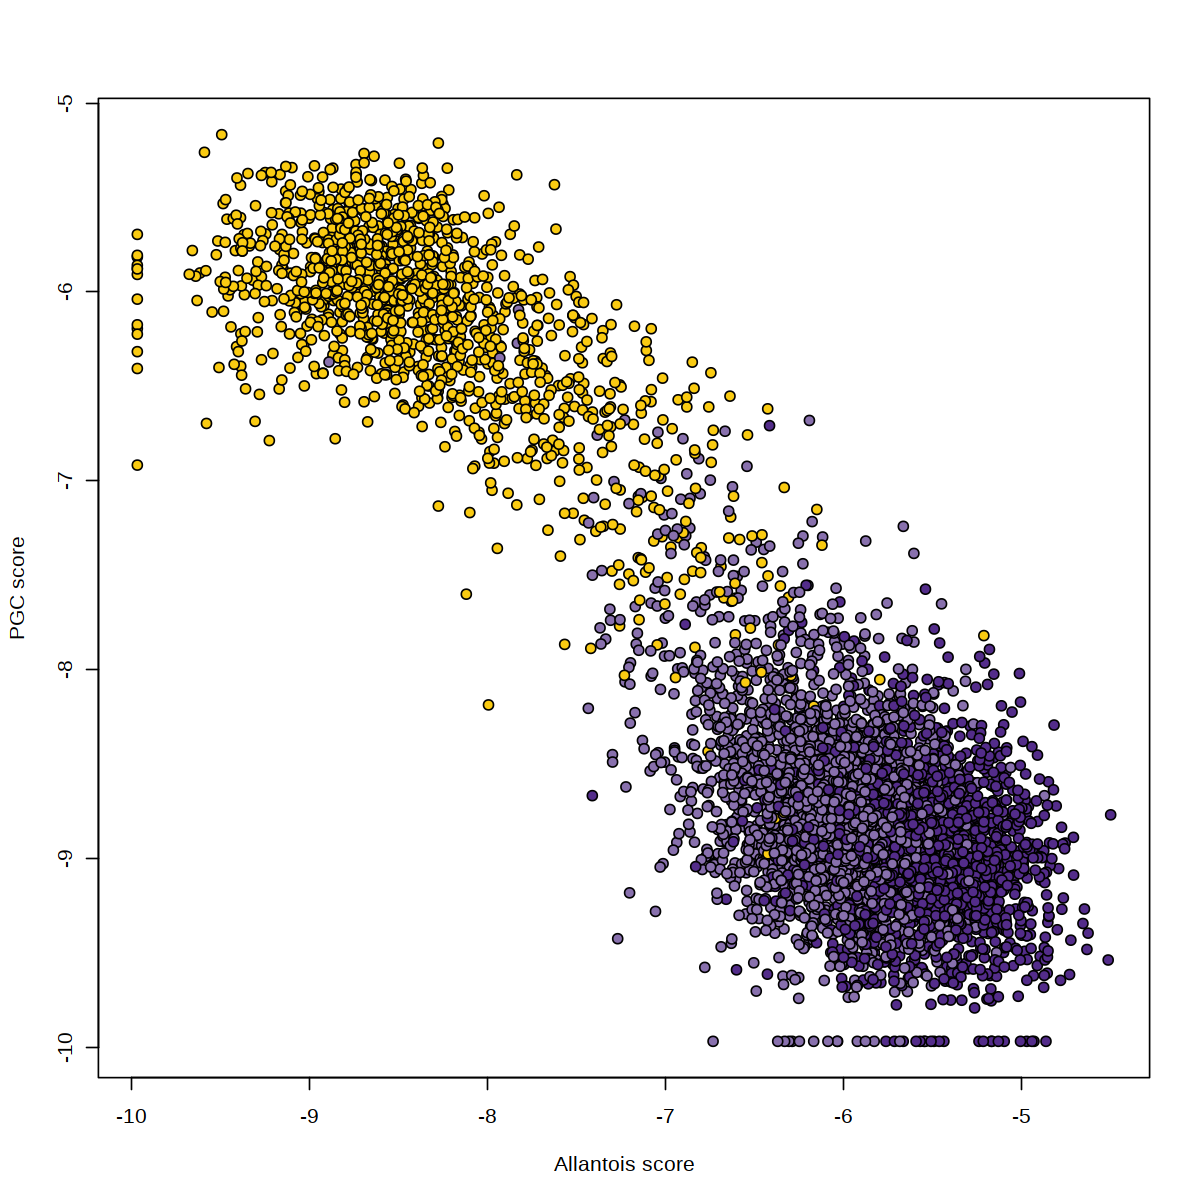

In [22]:
plot_size(10,10)

pgc_genes <- names(gene_cluster)[gene_cluster %in% c(1)]
pgc_genes <- setdiff(pgc_genes, c("Pou5f1", "Nanog", "Utf1", "Sox2"))
known_markers <- c("Psmb8","Sox17","Ifitm3","Prdm1","Tfap2c","Dnd1","Dppa3")
pgc_genes <- union(pgc_genes,known_markers)

clust_score_pgc = colSums(mat_all@mat[pgc_genes,pgc_lineage_cells.all])/colSums(mat_all@mat[,pgc_lineage_cells.all])
clust_score_pgc <- log2(clust_score_pgc + 1e-3)

allantois_genes <- names(gene_cluster)[gene_cluster %in% c(3,4,5)]
clust_score_allantois = colSums(mat_all@mat[allantois_genes,pgc_lineage_cells.all])/colSums(mat_all@mat[,pgc_lineage_cells.all])
clust_score_allantois <- log2(clust_score_allantois + 1e-3)


# plot(md_all[pgc_lineage_cells.all,"developmental_time"], clust_score_pgc[pgc_lineage_cells.all],pch = 21, cex = 1,
#      bg = mc_all@colors[mc_all@mc[pgc_lineage_cells.all]])

plot(clust_score_allantois[pgc_lineage_cells.all], clust_score_pgc[pgc_lineage_cells.all],pch = 21, cex = 1,
     bg = mc_all@colors[mc_all@mc[pgc_lineage_cells.all]], ylab = "PGC score", xlab = "Allantois score")

In [ ]:
pgc_genes <- names(gene_cluster)[gene_cluster %in% c(1)]
pgc_genes <- setdiff(pgc_genes, c("Pou5f1", "Nanog", "Utf1", "Sox2"))
known_markers <- c("Psmb8","Sox17","Ifitm3","Prdm1","Tfap2c","Dnd1","Dppa3")
pgc_genes <- union(pgc_genes,known_markers)

set.seed(1)
pgc_genes_clust <- kmeans(legc[pgc_genes,],centers = 10)
pgc_genes <- rev(names(as.array(pgc_genes_clust$cluster[order(as.numeric(pgc_genes_clust$cluster))])))

##########

included_colors = mc_embexe@color_key$color[c(10,26,27)]
mc_all_included = which(mc_all@colors %in% included_colors)
mc_all_included = intersect(mc_all_included, colnames(legc))

##########

shades_blues <- colorRampPalette(RColorBrewer::brewer.pal(9,name = "Blues"))(100)

annotation_col = data.frame(ct = col_to_ct[mc_all@colors],stringsAsFactors = F)
rownames(annotation_col) = c(1:nrow(annotation_col))

annotation_colors = list(ct = ct_to_col)

plot_size(5,8)

p <- pheatmap::pheatmap(mat = pmin(legc[pgc_genes,mc_all_included], -10),
                            treeheight_col = 0,
                            treeheight_row = 0,
                            cluster_cols = T,
                            cluster_rows = T,
                            show_colnames = F,
                            show_rownames = F,
                            legend = T,
                            annotation_legend = F,
                            color = shades_blues,
                            annotation_col = annotation_col,
                            border_color = "#D2D2D2",
                            annotation_colors = annotation_colors)

In [ ]:
allantois_genes <- names(gene_cluster)[gene_cluster %in% c(3,4,5)]

set.seed(1)
allantois_genes_clust <- kmeans(legc[allantois_genes,],centers = 10)
allantois_genes <- rev(names(as.array(allantois_genes_clust$cluster[order(as.numeric(allantois_genes_clust$cluster))])))

##########

included_colors = mc_embexe@color_key$color[c(10,26,27)]
mc_all_included = which(mc_all@colors %in% included_colors)
mc_all_included = intersect(mc_all_included, colnames(legc))

##########

annotation_col = data.frame(ct = col_to_ct[mc_all@colors],stringsAsFactors = F)
rownames(annotation_col) = c(1:nrow(annotation_col))

annotation_colors = list(ct = ct_to_col)

plot_size(5,8)

p <- pheatmap::pheatmap(mat = pmin(legc[allantois_genes,mc_all_included], -10),
                            treeheight_col = 0,
                            treeheight_row = 0,
                            cluster_cols = T,
                            cluster_rows = T,
                            show_colnames = F,
                            show_rownames = F,
                            legend = T,
                            annotation_legend = F,
                            color = shades_blues,
                            annotation_col = annotation_col,
                            border_color = "#D2D2D2",
                            annotation_colors = annotation_colors)

In [ ]:
col_to_ct_new <- c(col_to_ct, array(data = "PGC precursor", dim = 1, dimnames = list("#E2F700")))
ct_to_col_new <- c(ct_to_col, array(data = "#E2F700", dim = 1, dimnames = list("PGC precursor")))

mc_score_allantois <- colSums(egc[allantois_genes,])/colSums(egc)
mc_score_allantois <- log2(mc_score_allantois + 1e-5)

mc_score_pgc <- colSums(egc[pgc_genes,])/colSums(egc)
mc_score_pgc <- log2(mc_score_pgc + 1e-5)

included_colors = c(mc_embexe@color_key$color[c(10,26,27)])

mc_all_included = which(mc_all@colors %in% included_colors)
mc_all_included = intersect(mc_all_included, colnames(legc))

plot_size(6,6)
plot(x = mc_time_all[mc_all_included], main = "PGC score",
     y = mc_score_pgc[mc_all_included], 
     bg = mc_all@colors[as.numeric(mc_all_included)], 
     ylab = "PGC score", xlab = "Time [Et]",
     pch = 21, cex = 2)
abline(h = -8)
abline(h = -6.5)
abline(v = 8)

In [ ]:
col_vector <- mc_all@colors[as.numeric(mc_all_included)]
names(col_vector) <- mc_all_included

precursor_mcs <- names(mc_score_pgc[mc_all_included])[mc_score_pgc[mc_all_included] > -8 & 
                                                      mc_score_pgc[mc_all_included] < -6.5 & 
                                                      mc_time_all[mc_all_included] < 8]
col_vector[precursor_mcs] <- "#E2F700"

####################################################################################################################

pgc_precursor_mcs <- as.numeric(precursor_mcs)
pgc_precursor_cls_all <- names(mc_all@mc)[as.numeric(mc_all@mc) %in% as.numeric(pgc_precursor_mcs)]

mc_all@colors[pgc_precursor_mcs] <- "#E2F700"
names(mc_all@colors)[pgc_precursor_mcs] <- "PGC precursor"

mc_all@color_key[51,c("group","color")] <- c("PGC precursor","#E2F700")

pgc_precursor_cls.tetraploid <- intersect(pgc_precursor_cls_all, tetraploid_ko_cells)
pgc_precursor_cls.germline <- intersect(pgc_precursor_cls_all, germline_ko_cells)
pgc_precursor_cls.og2 <- intersect(pgc_precursor_cls_all, og2_cells)
pgc_precursor_cls.wt <- intersect(pgc_precursor_cls_all, wt_cells)

egc_pgc_precursors = mat_all@mat[genes_f,pgc_precursor_cls_all]
egc_pgc_precursors = t(t(egc_pgc_precursors)/colSums(egc_pgc_precursors))

####################################################################################################################

cls_all_inclded <- names(mc_all@mc)[as.numeric(mc_all@mc) %in% mc_all_included]
pgc_sc_score <- colSums(mat_all@mat[pgc_genes,cls_all_inclded])/colSums(mat_all@mat[,cls_all_inclded])
allantois_sc_score <- colSums(mat_all@mat[allantois_genes,cls_all_inclded])/colSums(mat_all@mat[,cls_all_inclded])

####################################################################################################################

cells_ref <- c(wt_cells, og2_cells)

pgc_mcs <- setdiff(pgc_mcs, pgc_precursor_mcs)
pgc_cls_all <- names(mc_all@mc)[as.numeric(mc_all@mc) %in% as.numeric(pgc_mcs)]

pgc_cls.tetraploid <- intersect(pgc_cls_all, tetraploid_ko_cells)
pgc_cls.germline <- intersect(pgc_cls_all, germline_ko_cells)
pgc_cls.og2 <- intersect(pgc_cls_all, og2_cells)
pgc_cls.wt <- intersect(pgc_cls_all, wt_cells)
pgc_cls.ref <- c(pgc_cls.og2,pgc_cls.wt)

## FIG 5f-g

In [ ]:
pgcs_ref.e7.5 <- pgc_cls.ref[md_all[ pgc_cls.ref,"developmental_time"] < 8.0]
pgcs_ref.e8.5 <- pgc_cls.ref[md_all[ pgc_cls.ref,"developmental_time"] < 9.0 & md_all[ pgc_cls.ref,"developmental_time"] > 8.0]
pgcs_ref.e9.5 <- pgc_cls.ref[md_all[ pgc_cls.ref,"developmental_time"] > 9.0]

df_density_plot_score = data.frame(cell = c(pgcs_ref.e7.5, pgcs_ref.e8.5, pgcs_ref.e9.5, pgc_cls.tetraploid),
                                   pgc_score = log2(pgc_sc_score[c(pgcs_ref.e7.5, pgcs_ref.e8.5, pgcs_ref.e9.5, pgc_cls.tetraploid)] + 1e-3),
                                   genotype = rep(c("Ref PGCs E7.5","Ref PGCs E8.5","Ref PGCs E9.5","Embryonic Bmp4-KO PGCs"),
                                                 times = c(length(pgcs_ref.e7.5),length(pgcs_ref.e8.5),length(pgcs_ref.e9.5),length(pgc_cls.tetraploid))))

options(repr.plot.width=7, repr.plot.height=7)
ggplot(data = df_density_plot_score,aes(x = pgc_score,color = genotype)) + geom_density(size = 1) + xlab("PGC score") +
scale_color_manual(values = c("Ref PGCs E7.5" = "#81BAD8", 
                             "Ref PGCs E8.5" = "#3784B6",
                             "Ref PGCs E9.5" = "#08306B",
                             "Embryonic Bmp4-KO PGCs" = "red")) +
theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
                axis.text = element_text(size = 12),
                plot.subtitle = element_text(hjust = 0.5, size = 10),
                axis.title = element_text(face = "bold",size = 12),
                panel.grid = element_blank(),panel.border = element_rect(fill=NA),legend.position="left")

####################################################################################################################

s_genes = c("Pcna", "Rrm2", "Mcm5", "Mcm6", "Mcm4", "Ung", "Mcm7", "Mcm2","Uhrf1", "Orc6", "Tipin")
s_genes = intersect(rownames(egc), s_genes)

m_genes = c("Mki67","Cenpf","Top2a","Smc4","Ube2c","Ccnb1","Cdk1","Arl6ip1","Ankrd11","Hmmr","Cenpa","Tpx2","Aurka","AB349069;Kif4", "Kif2c","Bub1b","Ccna2", "Kif23","Kif20a","Sgol2a","Smc2", "Kif11", "Cdca2","Incenp","Cenpe")
m_genes = intersect(rownames(egc), m_genes)

m_0 = 0.01
s_0 = 0.005

tot  = colSums(mat_all@mat[genes_f,])
s_tot = colSums(mat_all@mat[s_genes,])
s_score = s_tot/tot

m_tot = colSums(mat_all@mat[m_genes,])
m_score = m_tot/tot

df_plot = data.frame(cell = c(pgcs_ref.e7.5, pgcs_ref.e8.5, pgcs_ref.e9.5, pgc_cls.tetraploid),
                     m_phase_score = m_score[c(pgcs_ref.e7.5, pgcs_ref.e8.5, pgcs_ref.e9.5, pgc_cls.tetraploid)],
                     s_phase_score = s_score[c(pgcs_ref.e7.5, pgcs_ref.e8.5, pgcs_ref.e9.5, pgc_cls.tetraploid)],
                     genotype = rep(c("Ref PGCs E7.5","Ref PGCs E8.5","Ref PGCs E9.5","Embryonic Bmp4-KO PGCs"),
                                    times = c(length(pgcs_ref.e7.5),length(pgcs_ref.e8.5),length(pgcs_ref.e9.5),length(pgc_cls.tetraploid))))

df_plot$m_plus_s_phase_score  = df_plot$m_phase_score + df_plot$s_phase_score

options(repr.plot.width=14, repr.plot.height=7)
ggplot(data = df_plot,aes(x = m_plus_s_phase_score,color = genotype)) + geom_density(size = 1) + xlab("Cell cycle score") +
scale_color_manual(values = c("Ref PGCs E7.5" = "#81BAD8", 
                             "Ref PGCs E8.5" = "#3784B6",
                             "Ref PGCs E9.5" = "#08306B",
                             "Embryonic Bmp4-KO PGCs" = "red")) +
theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
                axis.text = element_text(size = 12),
                plot.subtitle = element_text(hjust = 0.5, size = 10),
                axis.title = element_text(face = "bold",size = 12),
                panel.grid = element_blank(),panel.border = element_rect(fill=NA),legend.position="left")

## FIG 5i

In [ ]:
plot_size(6,6)
plot(x = mc_time_all[mc_all_included], main = "PGC score",
     y = mc_score_pgc[mc_all_included], 
     bg = col_vector, cex.lab = 1.5, cex.main = 2, cex.axis = 1.5,
     ylab = "PGC score", xlab = "Time [Et]",
     pch = 21, cex = 2)

## Extended Data Figure 13b - PGC precursor differential expression

In [ ]:
egc_all = t(t(mat_all@mat[genes_f,names(mc_all@mc)])/colSums(mat_all@mat[genes_f,names(mc_all@mc)]))

In [ ]:
plot_size(8,8)

reg = 5e-5
fold = 2

dge1 <- matrix(log2(rowMeans(egc_all[,pgc_precursor_cls.tetraploid]) + reg), dimnames = list(rownames(egc_all)))
dge2 <- matrix(log2(rowMeans(egc_all[,c(pgc_precursor_cls.wt)]) + reg), dimnames = list(rownames(egc_all)))
temp <- cbind(dge1[,1],dge2[,1])

colnames(temp) <- c("gexp.query", "gexp.ref")
temp <- as.data.frame(temp)

temp$diff <- temp$gexp.query - temp$gexp.ref

up <- rownames(temp)[temp$diff > log2(fold)]
dn <- rownames(temp)[temp$diff < -log2(fold)]

mark <- c("Dppa3", "Nanog","Prdm1", "Prdm14", "Tfap2c", "Sox2","Pou5f1", "Ifitm3","Nanos3","Alpl","Dnd1",
         "Hoxa9","Hoxc8","Hoxb6","Plac1","Mixl1","Smad6","Twist1","Hand1","Snai1")

rnms <- rownames(temp)
rnms <- subset(rnms , rnms %in% c(up,dn,mark))

temp$log <- NA
temp$log[rownames(temp) %in% dn] <- "dn"
temp$log[rownames(temp) %in% up] <- "up"
temp$log[rownames(temp) %in% mark] <- "mark"
temp$log[which(is.na(temp$log))] <- "n"

ylims <- c(log2(reg),max(c(temp$gexp.query,temp$gexp.ref)))
title.nm <- "PGC precursors differential expression\nWT vs Embryonic-Bmp4-KO"

pa <- ggplot(data = temp,aes(gexp.ref,gexp.query,col=log)) +
  geom_point(size = 3) +
geom_abline(slope = 1) +
geom_abline(slope = 1, intercept = -log2(fold),linetype="dashed",col="grey") +
geom_abline(slope = 1, intercept = log2(fold),linetype="dashed",col="grey") +
  ggtitle(title.nm) +
    xlim(ylims) + 
    ylim(ylims) + 
    xlab("absolute expression\nWT PGC precursors") +
  ylab("Embryonic Bmp4-KO PGC precursors\nabsolute expression") +
    theme(plot.title = element_text(face = "bold",hjust = 0.5)) +

  scale_color_manual(values = c("dn"="#A74C48", 
                                "up"="#3D6BA9",
                                "mark" = "black",
                                "n"="#E5E5E5"))

p1 <- pa  +  geom_point(data=subset(temp, rownames(temp) %in% rnms),
                        aes(gexp.ref,gexp.query), size = 3) +

geom_text_repel(data=subset(temp, rownames(temp) %in% mark),
                            max.overlaps = 50,
                            aes(gexp.ref,gexp.query,
                                col = "black",
                                label=intersect(rownames(temp),mark)), size = 6, force = 80) +

theme(legend.position = "none", text = element_text(size = 10),
                panel.border = element_rect(fill=NA, size = 1))
print(p1)

## EDF 12f

In [ ]:
cells_ref <- c(wt_cells, og2_cells)

pgc_mcs <- setdiff(pgc_mcs, pgc_precursor_mcs)
pgc_cls_all <- names(mc_all@mc)[as.numeric(mc_all@mc) %in% as.numeric(pgc_mcs)]

pgc_cls.tetraploid <- intersect(pgc_cls_all, tetraploid_ko_cells)
pgc_cls.germline <- intersect(pgc_cls_all, germline_ko_cells)
pgc_cls.og2 <- intersect(pgc_cls_all, og2_cells)
pgc_cls.wt <- intersect(pgc_cls_all, wt_cells)
pgc_cls.ref <- c(pgc_cls.og2,pgc_cls.wt)

pgc_sc_score <- log2(colSums(mat_all@mat[pgc_genes,])/colSums(mat_all@mat) + 1e-3)

tetraploid_time_sc <- tetraploid_time_sc_df$developmental_time
names(tetraploid_time_sc) <- tetraploid_time_sc_df$cell

plot_size(5,5)

plot(x =  md_all[pgc_cls.og2,"developmental_time"], y = pgc_sc_score[pgc_cls.og2], cex = .8, pch = 19, ylim = c(min(pgc_sc_score),max(pgc_sc_score)))
points(x =  md_all[pgc_cls.tetraploid,"developmental_time"], y = pgc_sc_score[pgc_cls.tetraploid], cex = .8,col = "red", pch = 19)
points(x =  md_all[pgc_cls.wt,"developmental_time"], y = pgc_sc_score[pgc_cls.wt], col = "blue", cex = .8,pch = 19)
abline(h = max(pgc_sc_score[pgc_cls.tetraploid]), lty = "dashed")
abline(h = min(pgc_sc_score[pgc_cls.tetraploid]), lty = "dashed")
legend(x = 7.2, y = -3, legend = c("OG2 PGCs","Embryonic Bmp4-KO PGCs","WT PGCs"), box.lwd = 0, cex = 1.5,
       pch = 19, col = c("black","red","blue"))

pgcs_f <- names(pgc_sc_score)[pgc_sc_score >= min(pgc_sc_score[pgc_cls.tetraploid]) & pgc_sc_score <= max(pgc_sc_score[pgc_cls.tetraploid]) ]

pgcs_ref <- intersect(pgcs_f, pgc_cls.ref)
pgcs_query <- intersect(pgcs_f, pgc_cls.tetraploid)

egc_pgc_all <- t(t(mat_all@mat[genes_f,c(pgcs_ref,pgcs_query)])/colSums(mat_all@mat[genes_f,c(pgcs_ref,pgcs_query)]))

In [ ]:
plot_size(8,8)
reg = 5e-5
fold = log2(2)

dge1 <- matrix(log2(rowMeans(egc_pgc_all[,pgcs_query]) + reg), dimnames = list(rownames(egc_pgc_all)))
dge2 <- matrix(log2(rowMeans(egc_pgc_all[,pgcs_ref]) + reg), dimnames = list(rownames(egc_pgc_all)))
temp <- cbind(dge1[,1], dge2[,1])

colnames(temp) <- c("gexp.query", "gexp.ref")
temp <- as.data.frame(temp)

temp$diff <- temp$gexp.query - temp$gexp.ref

up <- rownames(temp)[temp$diff > fold]
dn <- rownames(temp)[temp$diff < -fold]

mark <- c("Dppa3", "Nanog","Prdm1", "Prdm14", "Tfap2c", "Sox2","Pou5f1", "Ifitm3","Nanos3","Alpl","Dnd1")

rnms <- rownames(temp)
rnms <- subset(rnms , rnms %in% c(up,dn,mark))

temp$log <- NA
temp$log[rownames(temp) %in% dn] <- "dn"
temp$log[rownames(temp) %in% up] <- "up"
temp$log[rownames(temp) %in% mark] <- "mark"
temp$log[which(is.na(temp$log))] <- "n"

ylims <- c(log2(reg),max(c(temp$gexp.query,temp$gexp.ref)))
xlims <- c(log2(reg),max(c(temp$gexp.query,temp$gexp.ref)))

title.nm <- sprintf("PGC differential expression\n#WT PGCs = %s, #KO PGCs = %s", length(pgcs_ref), length(pgcs_query))

pa <- ggplot(data = temp,aes(gexp.ref,gexp.query,col=log)) +
  geom_point(size = 1.5) +
  geom_abline(slope = 1,col="darkgrey") +
  geom_abline(slope = 1, intercept = fold, col = "gray70",linetype = 'dashed') +
  geom_abline(slope = 1, intercept = -fold, col = "gray70",linetype = 'dashed') +
  ggtitle(title.nm) +
  xlim(xlims) + 
  ylim(ylims) + 
  xlab("absolute expression\nWT PGC") +
  ylab("Embryonic Bmp4-KO PGC\nabsolute expression") +

  scale_color_manual(values = c("up"="#08519C",
                                "dn"="#CB181D",
                                "mark"="black",
                                "n"="#CCCCCC"))

p1 <- pa  + geom_text_repel(data=subset(temp, rownames(temp) %in% rnms),
                            aes(gexp.ref,gexp.query,
                                label=rnms, 
                                col  = "black",
                                size = 7), force = 30,max.overlaps = 100) +

            geom_point(data=subset(temp, rownames(temp) %in% rnms),
                     aes(gexp.ref,gexp.query), size = 1.5
                      ) +

            theme(legend.position = "none", 
                  plot.title = element_text(face = "bold",hjust = 0.5),
                  text = element_text(size = 12),
                  panel.border = element_rect(fill=NA, size = 1))


print(p1)